## LSTM

### Import Libraries

In [506]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report
import optuna

### Import Data

In [480]:
def load_datasets(directory):
    datasets = {}
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        datasets[filename] = pd.read_csv(filepath)
    return datasets

In [481]:
# Load all datasets
lifting_data = load_datasets('lifting')
wind_data = load_datasets('wind')
vehicle_data = load_datasets('vehicle')

In [482]:
lifting_data['l_01.csv'].head()

,Timestamp (ns),Acc_x,Acc_y,Acc_z,Anglvel_x,Anglvel_y,Anglvel_z
0,1720546724141749884,-9.124995,0.459360,3.148530,-0.053236,-0.074531,0.013841
1,1720546724151734054,-9.153705,0.401940,3.167670,-0.062819,-0.074531,0.013841
2,1720546724161718954,-9.129780,0.401940,3.124605,-0.060689,-0.076660,0.013841
3,1720546724171703404,-9.158490,0.416295,3.143745,-0.054301,-0.077725,0.013841
4,1720546724181687964,-9.144135,0.401940,3.143745,-0.059625,-0.077725,0.012777


### Plot the Data

In [483]:
# Function to plot all parameters for a given dataset
def plot_time_series(data, filename):
    plt.figure(figsize=(14, 8))
    
    # Plot acceleration data
    plt.subplot(2, 1, 1)
    plt.plot(data['Timestamp (ns)'], data['Acc_x'], label='Acc_x')
    plt.plot(data['Timestamp (ns)'], data['Acc_y'], label='Acc_y')
    plt.plot(data['Timestamp (ns)'], data['Acc_z'], label='Acc_z')
    plt.title(f'Acceleration - {filename}')
    plt.xlabel('Time (ns)')
    plt.ylabel('Acceleration')
    plt.legend()
    
    # Plot angular velocity data
    plt.subplot(2, 1, 2)
    plt.plot(data['Timestamp (ns)'], data['Anglvel_x'], label='Anglvel_x')
    plt.plot(data['Timestamp (ns)'], data['Anglvel_y'], label='Anglvel_y')
    plt.plot(data['Timestamp (ns)'], data['Anglvel_z'], label='Anglvel_z')
    plt.title(f'Angular Velocity - {filename}')
    plt.xlabel('Time (ns)')
    plt.ylabel('Angular Velocity')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [484]:
# Function to plot all files in a directory
def plot_all_time_series(directory, datasets):
    for filename, data in datasets.items():
        plot_time_series(data, filename)

In [485]:
# plot_all_time_series('vehicle', vehicle_data)

In [486]:
# plot_all_time_series('wind', wind_data)

In [487]:
# plot_all_time_series('lifting', lifting_data)

### Adjusting Sequence Lengths

In [488]:
# Function to truncate sequences with an adjustable lookback if the initial truncation is too short
def truncate_sequences_based_on_change(datasets, threshold=1, lookback=50, target_length=500):
    truncated_datasets = {}
    for filename, df in datasets.items():
        # Calculate the absolute difference for each column
        diffs = df[['Acc_x', 'Acc_y', 'Acc_z', 'Anglvel_x', 'Anglvel_y', 'Anglvel_z']].diff().abs()

        # Try to find the first index where any of the columns exceed the threshold
        critical_indices = diffs[(diffs > threshold).any(axis=1)].index
        
        if not critical_indices.empty:
            critical_index = critical_indices[0]
        else:
            critical_index = len(df) - target_length

        # Initial truncation with default lookback
        start_index = max(0, critical_index - lookback)
        truncated_df = df.iloc[start_index:start_index + target_length]

        # Check if the truncated sequence is too short
        if len(truncated_df) < target_length:
            # If too short, ensure the sequence goes to the end of the dataset
            start_index = max(0, len(df) - target_length)
            truncated_df = df.iloc[start_index:]

        # Store the truncated dataframe
        truncated_datasets[filename] = truncated_df

    return truncated_datasets

In [489]:
# Apply the truncation method
vehicle_data_truncated = truncate_sequences_based_on_change(vehicle_data)
wind_data_truncated = truncate_sequences_based_on_change(wind_data)
lifting_data_truncated = truncate_sequences_based_on_change(lifting_data)

In [490]:
# plot_all_time_series('vehicle', vehicle_data_truncated)

In [491]:
# plot_all_time_series('wind', wind_data_truncated)

In [492]:
# plot_all_time_series('lifting', lifting_data_truncated)

In [493]:
# Function to check if all datasets have the specified length
def check_dataset_lengths(datasets, expected_length=500):
    for filename, df in datasets.items():
        if len(df) != expected_length:
            print(f"File {filename} does not have {expected_length} data points. It has {len(df)}.")

In [494]:
# Check the lengths of the truncated datasets
check_dataset_lengths(vehicle_data_truncated)
check_dataset_lengths(wind_data_truncated)
check_dataset_lengths(lifting_data_truncated)

### Normalize the Data

In [495]:
# Function to normalize a single DataFrame
def normalize_data(df):
    scaler = MinMaxScaler()
    # Explicitly create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = df.copy()
    # Columns to normalize (excluding 'Timestamp (ns)')
    columns_to_normalize = ['Acc_x', 'Acc_y', 'Acc_z', 'Anglvel_x', 'Anglvel_y', 'Anglvel_z']
    df_copy[columns_to_normalize] = scaler.fit_transform(df_copy[columns_to_normalize])
    return df_copy

In [496]:
# Function to normalize all truncated datasets
def normalize_datasets(datasets):
    normalized_datasets = {}
    for filename, df in datasets.items():
        normalized_df = normalize_data(df)
        normalized_datasets[filename] = normalized_df
    return normalized_datasets

In [497]:
# Normalize the truncated datasets
lifting_data_normalized = normalize_datasets(lifting_data_truncated)
wind_data_normalized = normalize_datasets(wind_data_truncated)
vehicle_data_normalized = normalize_datasets(vehicle_data_truncated)

In [498]:
lifting_data_normalized['l_01.csv'].head()

,Timestamp (ns),Acc_x,Acc_y,Acc_z,Anglvel_x,Anglvel_y,Anglvel_z
124,1720546725379801294,0.776678,0.470790,0.397978,0.359722,0.502423,0.462151
125,1720546725389784744,0.778092,0.472509,0.397059,0.358333,0.504039,0.463147
126,1720546725399769024,0.779505,0.474227,0.397978,0.357639,0.504039,0.463147
127,1720546725409755654,0.785159,0.478522,0.404412,0.359028,0.502423,0.464143
128,1720546725419739054,0.784452,0.478522,0.402574,0.359028,0.502423,0.463147


### Add Resultant Acceleration to the Data

In [499]:
# Function to compute the resultant acceleration and angular velocity
def compute_resultant_features(df):
    df_copy = df.copy()  # Create a copy to avoid the warning
    # Compute resultant acceleration
    df_copy['Resultant_Acc'] = np.sqrt(df_copy['Acc_x']**2 + df_copy['Acc_y']**2 + df_copy['Acc_z']**2)
    # Compute resultant angular velocity
    df_copy['Resultant_Anglvel'] = np.sqrt(df_copy['Anglvel_x']**2 + df_copy['Anglvel_y']**2 + df_copy['Anglvel_z']**2)
    # Return only the resultant features
    return df_copy[['Acc_x', 'Acc_y', 'Acc_z', 'Resultant_Acc', 'Anglvel_x', 'Anglvel_y', 'Anglvel_z', 'Resultant_Anglvel']]

In [500]:
# Apply the resultant feature calculation to all datasets
def compute_resultant_for_datasets(datasets):
    resultant_datasets = {}
    for filename, df in datasets.items():
        resultant_df = compute_resultant_features(df)
        resultant_datasets[filename] = resultant_df
    return resultant_datasets

In [501]:
# Compute resultant acceleration and angular velocity for each dataset
vehicle_data_resultant = compute_resultant_for_datasets(vehicle_data_truncated)
wind_data_resultant = compute_resultant_for_datasets(wind_data_truncated)
lifting_data_resultant = compute_resultant_for_datasets(lifting_data_truncated)

### Label the Data

In [502]:
# Function to label datasets
def label_datasets(lifting_data, wind_data, vehicle_data):
    labeled_data = []
    labels = []
    
    # Label vehicle data as 1 (true collision)
    for df in vehicle_data.values():
        labeled_data.append(df.values)
        labels.append(1)
    
    # Label lifting and wind data as 0 (non-collision)
    for df in lifting_data.values():
        labeled_data.append(df.values)
        labels.append(0)
        
    for df in wind_data.values():
        labeled_data.append(df.values)
        labels.append(0)
    
    return np.array(labeled_data), np.array(labels)

In [503]:
# Re-label the datasets with the resultant acceleration
data, labels = label_datasets(lifting_data_resultant, wind_data_resultant, vehicle_data_resultant)

### Split the Data

In [504]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [505]:
# Example: Check the shape of the datasets
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (98, 500, 8)
Test data shape: (25, 500, 8)
Training labels shape: (98,)
Test labels shape: (25,)


In [ ]:
# Define a function to create the model, this will be used by Optuna
def create_lstm_model(trial):
    model = Sequential()
    
    # Suggest the number of units for LSTM layer
    units = trial.suggest_int('units', 25, 200)
    
    # Add LSTM layers with dropout
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Use Adam optimizer
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Define the objective function for Optuna
def objective(trial):
    model = create_lstm_model(trial)
    
    # Suggest batch size and number of epochs
    batch_size = trial.suggest_int('batch_size', 8, 64)
    epochs = trial.suggest_int('epochs', 20, 100)
    
    # Train the model
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Evaluate the model on the validation set
    score = model.evaluate(X_test, y_test, verbose=0)
    
    # Return the validation accuracy
    return score[1]

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Output the best parameters
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-08-25 00:46:51,053] A new study created in memory with name: no-name-d29515ff-8b93-4557-a8a6-8d08394f8970
[I 2024-08-25 00:47:49,548] Trial 0 finished with value: 0.9599999785423279 and parameters: {'units': 36, 'dropout_rate': 0.2569734412059277, 'learning_rate': 0.004317333254018587, 'batch_size': 43, 'epochs': 98}. Best is trial 0 with value: 0.9599999785423279.
[I 2024-08-25 00:49:25,858] Trial 1 finished with value: 0.9599999785423279 and parameters: {'units': 91, 'dropout_rate': 0.3314109717967171, 'learning_rate': 0.0023082829896881344, 'batch_size': 20, 'epochs': 62}. Best is trial 0 with value: 0.9599999785423279.
[I 2024-08-25 00:50:18,303] Trial 2 finished with value: 0.6399999856948853 and parameters: {'units': 101, 'dropout_rate': 0.2821825064749847, 'learning_rate': 1.1552086595415296e-05, 'batch_size': 46, 'epochs': 24}. Best is trial 0 with value: 0.9599999785423279.
[I 2024-08-25 00:56:16,372] Trial 3 finished with value: 0.9200000166893005 and parameters: {'un

In [474]:
# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Get the input shape from the training data
input_shape = (X_train.shape[1], X_train.shape[2])

# Create the model
model = create_lstm_model(input_shape)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict on the test set
predictions = model.predict(X_test, verbose=0)
predictions = (predictions > 0.5).astype(int)

Epoch 1/20
3/3 [==============================] - 4s 541ms/step - loss: 0.7394 - accuracy: 0.3974 - val_loss: 0.6221 - val_accuracy: 0.8000
Epoch 2/20
3/3 [==============================] - 1s 285ms/step - loss: 0.6061 - accuracy: 0.7564 - val_loss: 0.4815 - val_accuracy: 0.9000
Epoch 3/20
3/3 [==============================] - 1s 295ms/step - loss: 0.4893 - accuracy: 0.8462 - val_loss: 0.3908 - val_accuracy: 0.9000
Epoch 4/20
3/3 [==============================] - 1s 291ms/step - loss: 0.4192 - accuracy: 0.8846 - val_loss: 0.3199 - val_accuracy: 0.9000
Epoch 5/20
3/3 [==============================] - 1s 291ms/step - loss: 0.3407 - accuracy: 0.8974 - val_loss: 0.2618 - val_accuracy: 0.9000
Epoch 6/20
3/3 [==============================] - 1s 292ms/step - loss: 0.3136 - accuracy: 0.9103 - val_loss: 0.2030 - val_accuracy: 0.9500
Epoch 7/20
3/3 [==============================] - 1s 294ms/step - loss: 0.2481 - accuracy: 0.9359 - val_loss: 0.1469 - val_accuracy: 0.9500
Epoch 8/20
3/3 [====

In [475]:
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.96


In [476]:
# Generate classification report
report = classification_report(y_test, predictions)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.92      0.96        12

    accuracy                           0.96        25
   macro avg       0.96      0.96      0.96        25
weighted avg       0.96      0.96      0.96        25



In [477]:
def plot_sequence(sequence, label, title=""):
    plt.figure(figsize=(10, 4))
    plt.plot(sequence)
    plt.title(f"{title} (Label: {label})")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.show()

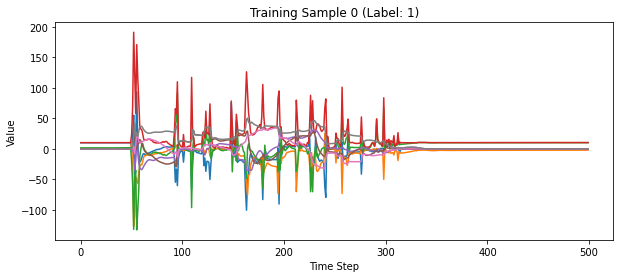

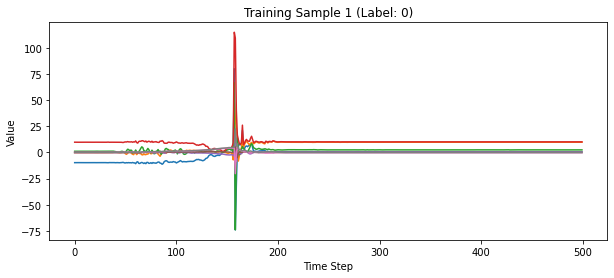

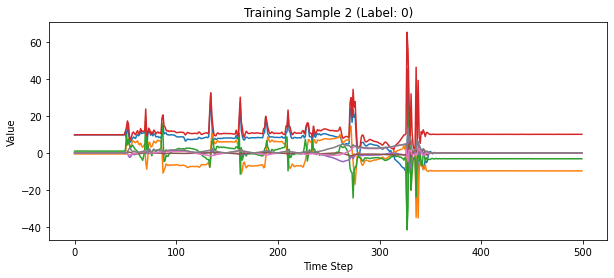

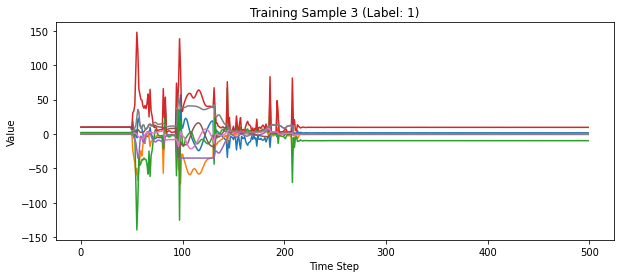

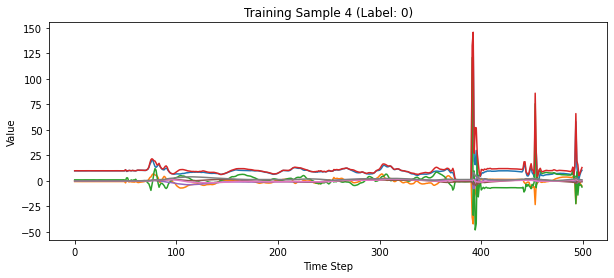

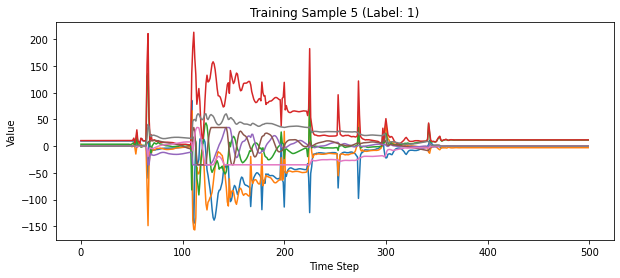

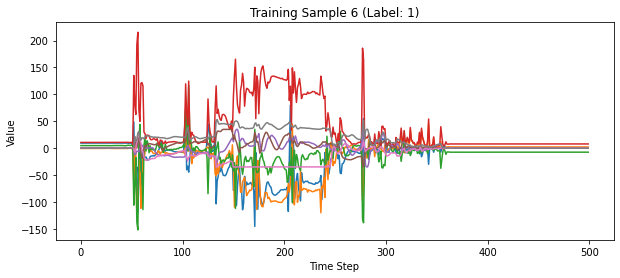

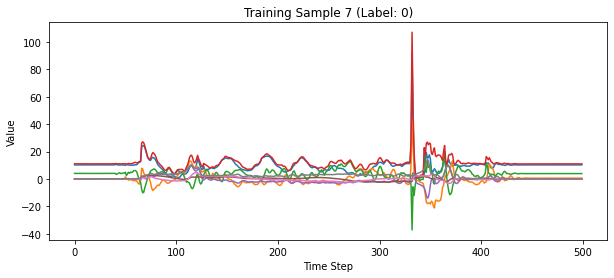

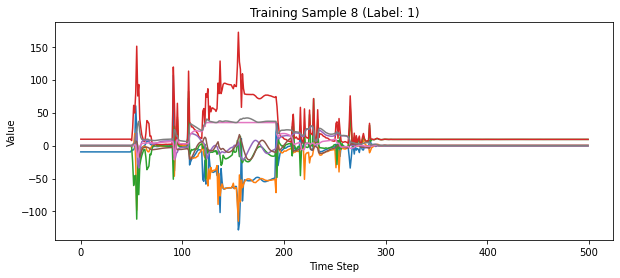

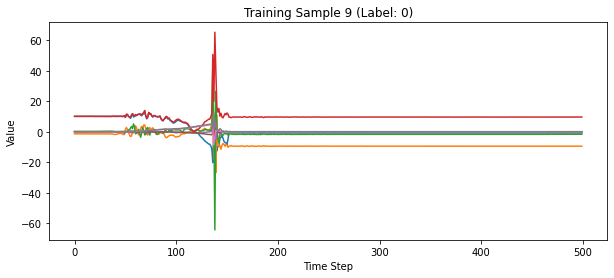

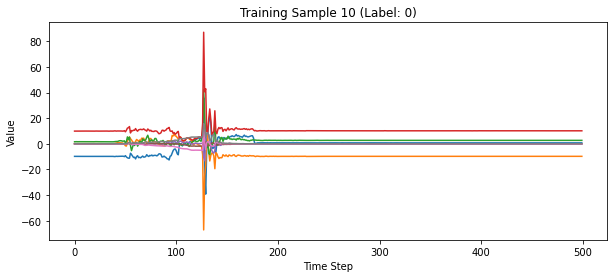

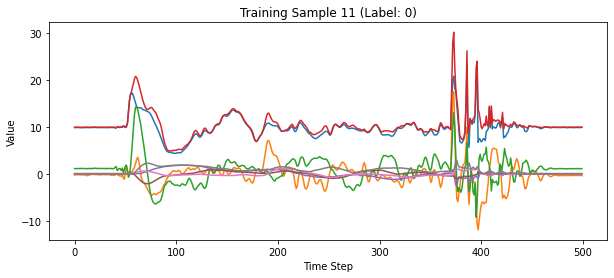

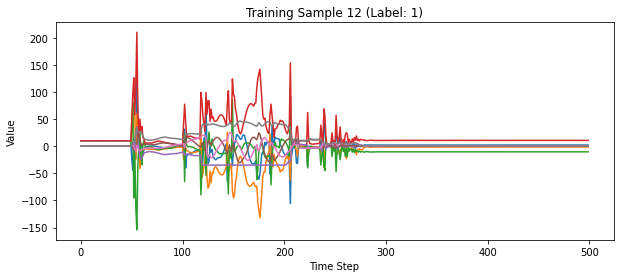

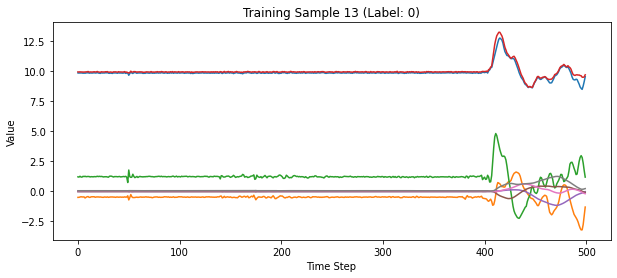

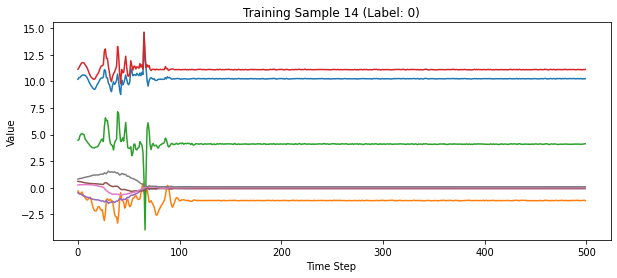

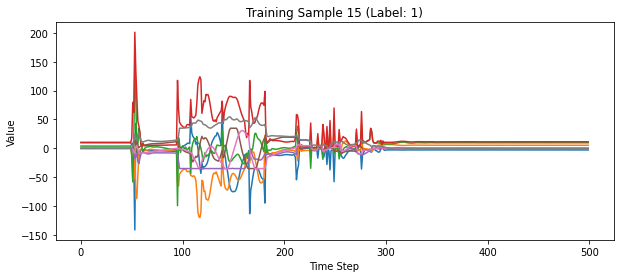

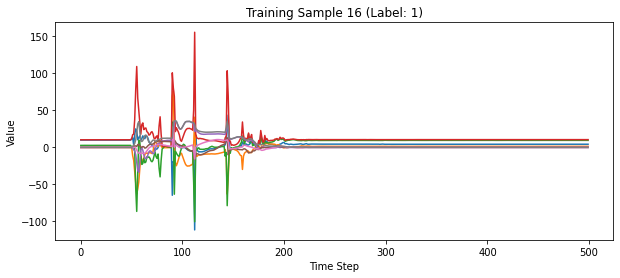

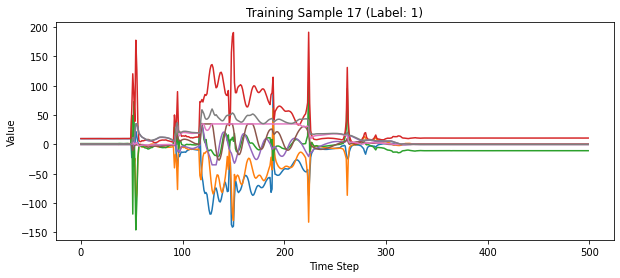

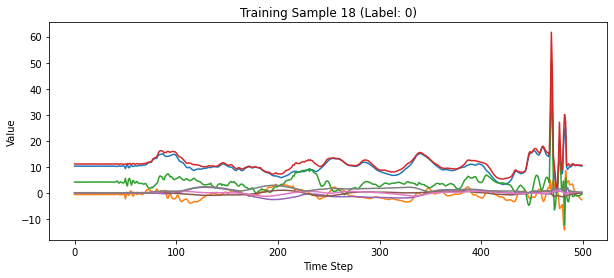

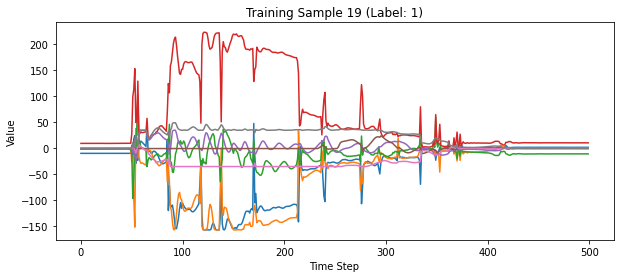

In [478]:
# Plot a few examples from each class
for i in range(20):  # Adjust the range as needed
    plot_sequence(X_train[i], y_train[i], title=f"Training Sample {i}")